In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.observational.handlers.cut import SingleStageCut
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

from cities.utils.cleaning_utils import list_available_features
from cities.utils.data_grabber import DataGrabber
from cities.utils.sdids import BayesSDID, run_svi_inference

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

In [41]:
# Let's load the data from the author's github
DATA_URL = "https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv"
data = pd.read_csv(DATA_URL, sep=";")

# Assign unique integer ids for each state and each time
data["unit_index"] = pd.factorize(data["State"].values)[0]
data["time_index"] = pd.factorize(data["Year"].values)[0]

# Model below assumes the response is coded as "y"
data["y"] = data["PacksPerCapita"].values.copy()

# Assign each unit to treatment or control group
data["in_treatment_group"] = 0
treated_units = data[data["treated"] == 1]["State"].unique()
data.loc[data["State"].isin(treated_units), "in_treatment_group"] = 1
    

In [6]:
sdid_cigarettes = BayesSDID(data)
guide_cigarettes = run_svi_inference(sdid_cigarettes, vi_family=AutoNormal, n_steps=5000)
samples_cigarettes = Predictive(sdid_cigarettes, guide=guide_cigarettes, num_samples=1000)()

[iteration 0001] loss: 32851.1403
[iteration 1000] loss: 12101.5194
[iteration 2000] loss: 11941.1133
[iteration 3000] loss: 11937.2298
[iteration 4000] loss: 11944.5013
[iteration 5000] loss: 11924.2255


In [42]:
print(list_available_features())


['transport', 'spending_transportation', 'gdp', 'spending_HHS', 'population', 'spending_commerce']


In [78]:

dg = DataGrabber()

outcome_dataset = 'gdp'
intervention_dataset = 'spending_HHS'
intervention_variable = 'total_obligated_amount'

dg.get_features_long([outcome_dataset, intervention_dataset])  #consider stdized
# REMOVE THE NEXT LINE LATER
dg.long[intervention_dataset].columns = dg.long[intervention_dataset].columns.str.replace('year', 'Year')

year = 2016

threshold = np.percentile(dg.long[intervention_dataset][dg.long[intervention_dataset]['Year'] == year]['total_obligated_amount'],.75)   


analysis_data = pd.merge(dg.long[outcome_dataset], dg.long[intervention_dataset], on=['GeoFIPS', 'GeoName', 'Year'])

# #TODO need to make sure this is systematic
analysis_data.rename(columns={'Value': outcome_dataset}, inplace=True)

analysis_data['unit_index']= pd.factorize(analysis_data['GeoFIPS'].values)[0]
analysis_data['time_index']= pd.factorize(analysis_data['Year'].values)[0]
analysis_data['y'] = analysis_data[outcome_dataset].values.copy()


intervened_states = analysis_data[analysis_data['Year'] == year]['GeoFIPS'][analysis_data[intervention_variable] > threshold]

print(round(len(intervened_states.unique())/len(analysis_data['GeoFIPS'].unique()) * 100, 2), "% of locations received this intervention in", year)

analysis_data["treated"] = 0
analysis_data["in_treatment_group"] = 0

treated_mask = (analysis_data['GeoFIPS'].isin(intervened_states))
unique_fips = analysis_data[treated_mask]['GeoFIPS'].unique()
deployment_mask = (analysis_data['GeoFIPS'].isin(unique_fips)) & (analysis_data['Year'] >= year)
analysis_data.loc[deployment_mask, 'treated'] = 1
in_treatment_mask = (analysis_data['GeoFIPS'].isin(unique_fips))
analysis_data.loc[in_treatment_mask, 'in_treatment_group'] = 1

analysis_data.sort_values(by='in_treatment_group', ascending=True, inplace=True)
analysis_data.reset_index(drop=True, inplace=True)

display(analysis_data.head())


56.5 % of locations received this intervention in 2016


,GeoFIPS,GeoName,Year,gdp,total_obligated_amount,unit_index,time_index,y,treated,in_treatment_group
0,1129,"Washington, AL",2017,100.322,530972.0,1768,6,100.322,0,0
1,33003,"Carroll, NH",2020,93.360,1977056.0,957,9,93.360,0,0
2,33001,"Belknap, NH",2020,101.844,500000.0,1911,9,101.844,0,0
3,19151,"Pocahontas, IA",2018,125.521,0.0,2259,7,125.521,0,0
4,32029,"Storey, NV",2020,332.233,2000000.0,2524,9,332.233,0,0


In [83]:
display(analysis_data[analysis_data['in_treatment_group'] == 1].head())

,GeoFIPS,GeoName,Year,gdp,total_obligated_amount,unit_index,time_index,y,treated,in_treatment_group
2288,17199,"Williamson, IL",2017,95.387,4.823702e+08,400,6,95.387,1,1
2289,31019,"Buffalo, NE",2018,109.876,3.900272e+07,919,7,109.876,1,1
2290,21069,"Fleming, KY",2017,96.460,7.657983e+07,544,6,96.460,1,1
2291,40069,"Johnston, OK",2018,141.205,2.147959e+08,1253,7,141.205,1,1
2292,40083,"Logan, OK",2018,100.627,3.029086e+06,1257,7,100.627,1,1


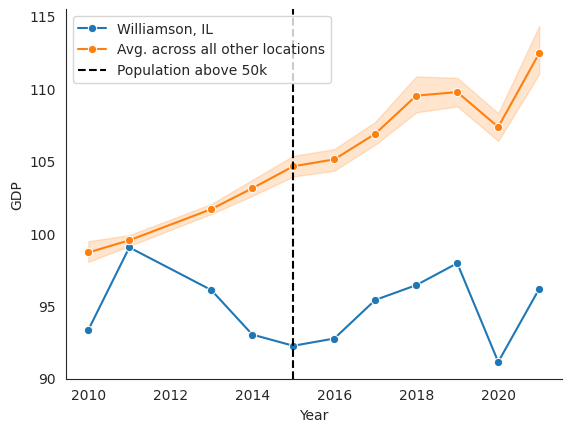

In [84]:
fips = 17199

sns.lineplot(
    x=analysis_data[analysis_data["GeoFIPS"] == fips]["Year"],
    y=analysis_data[analysis_data["GeoFIPS"] == fips]['gdp'],
    marker="o",
    label=analysis_data[analysis_data["GeoFIPS"] == fips]["GeoName"].unique()[0]
)

# The shaded area is the plot is the 95% confidence interval around the mean
sns.lineplot(
    x=analysis_data[analysis_data["GeoFIPS"] != fips]["Year"],
    y=analysis_data[analysis_data["GeoFIPS"] != fips][outcome_dataset],
    marker="o",
    label='Avg. across all other locations',
)

plt.axvline(
    2015, label="Population above 50k", color="black", linestyle="dashed"
)
plt.ylabel("GDP")
sns.despine()
plt.legend()

In [87]:
sdid_hss2016 = BayesSDID(analysis_data)
guide_hss2016 = run_svi_inference(sdid_hss2016, vi_family=AutoNormal, n_steps=5000)
samples_hss2016 = Predictive(sdid_hss2016, guide=guide_hss2016, num_samples=1000)()

ValueError: Expected parameter loc (Tensor of shape (5,)) of distribution Normal(loc: torch.Size([5]), scale: torch.Size([5])) to satisfy the constraint Real(), but found invalid values:
tensor([99.1615,     nan,     nan,     nan,     nan])
Trace Shapes:       
 Param Sites:       
Sample Sites:       
      w0 dist |     
        value |     
    w_co dist | 1339
        value | 1339
   lam_0 dist |     
        value |     
 lam_pre dist |    5
        value |    5
      mu dist |     
        value |     
    beta dist |   11
        value |   11
     tau dist |     
        value |     
   alpha dist | 3078
        value | 3078
Trace Shapes:
 Param Sites:
Sample Sites:

In [94]:
sdid = sdid_hss2016

w0, w_co = sdid.sample_synthetic_control_weights()
lam_0, lam_pre = sdid.sample_time_weights()
mu, beta, tau, alpha = sdid.sample_response_params()


print(
"N",    sdid.N,
"N_tr", sdid.N_tr,
"N_co", sdid.N_co,
"T_pre", sdid.T_pre,
"T_post", sdid.T_post,
"T", sdid.T,
"times_by_units", sdid.times_by_units.shape,  
"avg_y_post", sdid.avg_y_post_treat.shape,
"y_pre_treat_tr_avg", sdid.y_pre_treat_tr_avg.shape,
"y", sdid.y.shape, 
"treated", sdid.treated.shape,
"unit_index", len(sdid.unit_index),
"time_index", len(sdid.time_index),
"w0", w0,
"w_co", w_co.shape,
"lam_0", lam_0,
"lam_pre", lam_pre.shape,
"mu", mu,
"beta", beta.shape,
"tau", tau,
"alpha", alpha.shape,
)


print(sdid.times_by_units[:sdid.N_co].shape)

#display(w0 + sdid.times_by_units[:sdid.N_co,].mv(w_co))

# this time forward falls on its face
#sdid.forward()



N 3078 N_tr 1739 N_co 1339 T_pre 5 T_post 6 T 11 times_by_units torch.Size([11, 3078]) avg_y_post torch.Size([1339]) y_pre_treat_tr_avg torch.Size([5]) y torch.Size([20218]) treated torch.Size([20218]) unit_index 20218 time_index 20218 w0 tensor(-0.1334) w_co torch.Size([1339]) lam_0 tensor(3.7430) lam_pre torch.Size([5]) mu tensor(-0.9551) beta torch.Size([11]) tau tensor(3.5018) alpha torch.Size([3078])
torch.Size([11, 3078])


ValueError: Expected parameter loc (Tensor of shape (5,)) of distribution Normal(loc: torch.Size([5]), scale: torch.Size([5])) to satisfy the constraint Real(), but found invalid values:
tensor([99.6685,     nan,     nan,     nan,     nan])

In [8]:
joint_guide = run_svi_inference(BayesSDID(analysis_data), vi_family=AutoNormal, n_steps=5000)

# Get posterior samples from the joint guide
#joint_samples = Predictive(BayesSDID(analysis_data), guide=joint_guide, num_samples=1000)()

[iteration 0001] loss: 676647.6111


ValueError: Error while computing log_prob at site 'w_co':
Expected value argument (Tensor of shape (2108,)) to be within the support (Simplex()) of the distribution Dirichlet(concentration: torch.Size([2108])), but found invalid values:
tensor([0.0006, 0.0006, 0.0006,  ..., 0.0005, 0.0005, 0.0005],
       grad_fn=<ExpandBackward0>)
Trace Shapes:       
 Param Sites:       
Sample Sites:       
      w0 dist |     
        value |     
     log_prob |     
    w_co dist | 2108
        value | 2108

In [ ]:
# It seems that you are trying to perform element-wise multiplication between two tensors, but the sizes of these tensors are not compatible. The error message indicates that the size of w_co_tr at dimension 0 is 61760, while the size of lam_pre_post at dimension 0 is 1209. These sizes should match if you want to perform element-wise operations between them.

# To resolve this issue, you need to ensure that the dimensions of these tensors align correctly for element-wise operations. You might want to review how w_co_tr, lam_pre_post, self.unit_index, and self.time_index are defined and used in your model to make sure they have compatible shapes.

# It's possible that there's a data processing or indexing issue that's causing this shape mismatch. You may need to double-check how your data is structured and how it's being used within your model, especially when calculating w_co_tr and lam_pre_post.